# Experiment 3

*Hypothesis*: Zeph will work at scale with Diamond-Miner. 

In [2]:
from pathlib import Path


exp_dir = Path("./resources/data/measurements/exp3/")

with (exp_dir / "production.txt").open("r") as fd:
    production_uuids = [uuid.strip() for uuid in fd.readlines()]

In [3]:
# Get Iris API / database credentials
import json
from zeph.drivers import create_auth_header, get_database_url

config = json.load(open("config.json"))
headers = create_auth_header(config["iris_url"], config["iris_username"], config["iris_password"])
database_url = get_database_url(config["iris_url"], headers)

## Links

In [15]:
from diamond_miner.queries import GetLinks
from zeph.drivers import get_previous_measurement_agents

def sanitize_uuid(uuid):
    return str(uuid).replace("-", "_")


def get_links(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(config["iris_url"], measurement_uuid, headers)
    
    distinct_links = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for link in GetLinks().execute_iter(database_url, measurement_id):
            distinct_links.add((link["near_addr"], link["far_addr"])) 
    return distinct_links

In [17]:
# Estimated computing time: ~10 minutes

production_n_links = []
for uuid in production_uuids:
    production_n_links.append(len(get_links(uuid)))
production_zeph_n_links = []

print(production_n_links)

[
    10436832,
    12409675,
    15053553,
    12544834,
    14955987,
    16111646,
    16105639,
    17539163,
    16658761,
    19890422
]

In [6]:
import matplotlib.ticker as ticker


class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        ticker.ScalarFormatter.__init__(self, useOffset=offset, useMathText=mathText)
    
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

<Figure size 432x288 with 1 Axes>

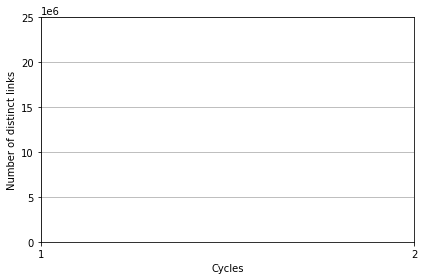

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "production": production_n_links,
})

ax = sns.lineplot(data=data, legend = False)

ax.set(xlabel="Cycles", ylabel="Number of distinct links")
ax.set(ylim=(0, 25_000_000))

ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 10)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(1, 11)))

ax.yaxis.set_major_formatter(OOMFormatter(6, "%g", mathText=False))
ax.grid()


plt.tight_layout()
plt.savefig("./resources/figures/exp3_links.pdf")
plt.show()

## Nodes

In [19]:
from diamond_miner.queries import GetNodes

def get_nodes(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(config["iris_url"], measurement_uuid, headers)
    
    distinct_nodes = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for node in GetNodes().execute_iter(database_url, measurement_id):
            distinct_nodes.add(node["reply_src_addr"]) 
    return distinct_nodes

In [20]:
# Estimated computing time: ~7 minutes

production_n_nodes = []
for uuid in production_uuids:
    production_n_nodes.append(len(get_nodes(uuid)))
production_zeph_n_nodes = []

print(production_n_nodes)

[2090101, 2505044, 2778420, 2827698, 2909473, 3025584, 3117979, 3195673, 3224954, 3288325]

<Figure size 432x288 with 1 Axes>

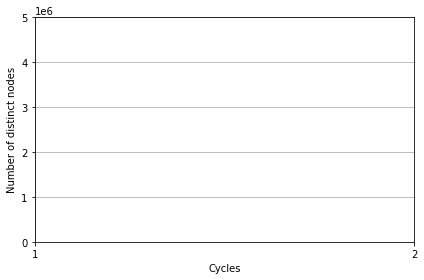

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "production": production_n_nodes,
})

ax = sns.lineplot(data=data, legend = False)

ax.set(xlabel="Cycles", ylabel="Number of distinct nodes")
ax.set(ylim=(0, 5_000_000))

ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 10)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(1, 11)))
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp3_nodes.pdf")
plt.show()

## Probes 

In [11]:
import requests 

def get_statistic(measurement_uuid, statistic):    
    data = requests.get(config["iris_url"] + f"/measurements/{measurement_uuid}", headers=headers)

    packets_sent = 0
    for agent in data.json()["agents"]:
        for probing_round in agent["probing_statistics"].values():
            packets_sent += probing_round.get(statistic, 0)
    return packets_sent

In [12]:
production_n_probes = []
for uuid in production_uuids:
    production_n_probes.append(get_statistic(uuid, "packets_sent"))

print(production_n_probes)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /var/folders/rv/1898p2xd2dg1m1tg751kx7j80000gn/T/ipykernel_4163/4276465768.py:3 in        │
│ <module>                                                                                  │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/var/folders/rv/1898p2xd2dg1m1tg751kx7j80000gn/T/ipykernel_4163/4276465768.py'           │
│ /var/folders/rv/1898p2xd2dg1m1tg751kx7j80000gn/T/ipykernel_4163/3918235546.py:4 in        │
│ get_statistic                                                                             │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/var/folders/rv/1898p2xd2dg1m1tg751kx7j80000gn/T/ipykernel_4163/3918235546.py'           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'iris_url' is not defined

<Figure size 432x288 with 1 Axes>

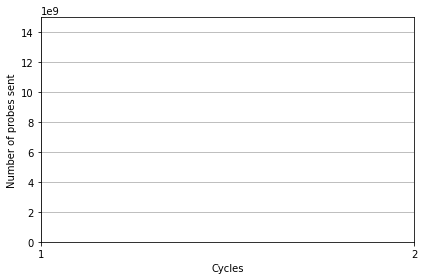

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "production": production_n_probes,
})

ax = sns.lineplot(data=data, legend = False)

ax.set(xlabel="Cycles", ylabel="Number of probes sent")
ax.set(ylim=(0, 15_000_000_000))

ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 10)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(1, 11)))

ax.yaxis.set_major_formatter(OOMFormatter(9, "%g", mathText=False))

ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp3_probes.pdf")
plt.show()